In [1]:
import numpy as np
import scipy.io
import matlab.engine
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from pathlib import Path

#### Load matlab data

In [2]:
feats = scipy.io.loadmat('output/feats4T.mat')
labels = scipy.io.loadmat('output/labels4T.mat')

feats = feats['features']
labels = labels['lp']

X = torch.Tensor(feats)
Y = torch.Tensor(labels)

In [3]:
Y = Y.T
Y.shape

torch.Size([480, 3])

In [4]:
X = X.T
X = torch.flatten(X, start_dim=1, end_dim=2)
X = X[:, None, :, :]

X.shape

torch.Size([480, 1, 16, 48])

# sample shape: 16x48

In [5]:
dataset = TensorDataset(X, Y)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

#### Define model

In [7]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        linear_in_dim = int(16/2/2/2*48/2/2/2*64)
        self.linear1 = nn.Linear(linear_in_dim, 300)
        self.linear2 = nn.Linear(300, 100)
        self.linear3 = nn.Linear(100, 3)

    
    def forward(self, x):
        out = self.seq(x)
        out = out.view(out.size(0), -1) # flatten to (batch size, int)
        out = F.relu(self.linear1(out))
        out = F.relu(self.linear2(out))
        out = self.linear3(out)
        return out
        
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(48, 20),
            nn.BatchNorm1d(20),
            nn.ReLU(),
            
            nn.Linear(20, 10),
            nn.BatchNorm1d(10),
            nn.ReLU(),
            
            nn.Linear(10, 3) # x,y,z outputs
        )
    def forward(self, x):
        return self.seq(x)

def EucLoss(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    assert a.shape == b.shape
    assert b.shape[-1] == 3
    return torch.sum((a-b).square(), dim=-1).sqrt().mean()

def EucLossSquared(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    assert a.shape == b.shape
    assert b.shape[-1] == 3
    return torch.sum((a-b).square(), dim=-1).mean()


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MyCNN().to(device)
model

MyCNN(
  (seq): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear1): Linear(in_features=768, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=3, bias=True)
)

In [9]:
crit = EucLoss
# crit = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

#### Training/Evaluating NN

In [10]:
num_epochs = 300
loss_tracker = np.zeros((num_epochs, 2))

num_train_batches = len(train_loader)
num_test_batches = len(test_loader)

for epoch in range(num_epochs):
    train_loss = 0
    test_loss = 0

    
    model = model.train()
    
    for batch_idx, (ft, lbl) in enumerate(train_loader):
        ft, lbl = ft.to(device), lbl.to(device)
        optimizer.zero_grad()
        output = model(ft)
        loss = crit(output, lbl)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * ft.shape[0] / len(train_dataset)
    train_loss /= num_train_batches
    loss_tracker[epoch, 0] = train_loss
        
        
    model = model.eval()
    
    with torch.no_grad():
        for batch_idx, (ft, lbl) in enumerate(test_loader):
            ft, lbl = ft.to(device), lbl.to(device)
            output = model(ft)
            loss = crit(output, lbl)
            test_loss += loss.item() * ft.shape[0] / len(test_dataset)
    test_loss /= num_test_batches
    loss_tracker[epoch, 1] = test_loss
            
    print('Epoch {} | Training loss = {} | Test loss = {}'.format(epoch, train_loss, test_loss))

Epoch 0 | Training loss = 0.42350183592902285 | Test loss = 1.5698003768920898
Epoch 1 | Training loss = 0.3139956345160802 | Test loss = 1.0105532275305855
Epoch 2 | Training loss = 0.2414625220828586 | Test loss = 0.9665693706936307
Epoch 3 | Training loss = 0.2192863689528571 | Test loss = 0.8716000186072455
Epoch 4 | Training loss = 0.21410890585846368 | Test loss = 0.8864777882893881
Epoch 5 | Training loss = 0.2130281196700202 | Test loss = 0.8697684341006808
Epoch 6 | Training loss = 0.21234745449490014 | Test loss = 0.8716558615366617
Epoch 7 | Training loss = 0.2121963335408105 | Test loss = 0.86919633547465
Epoch 8 | Training loss = 0.21191306246651545 | Test loss = 0.8701087103949653
Epoch 9 | Training loss = 0.21298700239923266 | Test loss = 0.869618813196818
Epoch 10 | Training loss = 0.21163597371843124 | Test loss = 0.8693852424621582
Epoch 11 | Training loss = 0.21172724664211276 | Test loss = 0.8692910671234131
Epoch 12 | Training loss = 0.21219598750273386 | Test loss

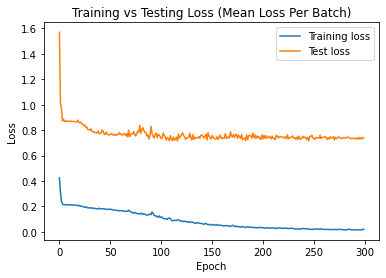

In [11]:
img_dir = Path('./loss_plots')
img_dir.mkdir(parents=True, exist_ok=True)

plt.figure()
plt.plot(loss_tracker)
plt.title('Training vs Testing Loss (Mean Loss Per Batch)')
plt.legend(['Training loss', 'Test loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig(img_dir / '3conv_3lin.png')

In [12]:
# save model
model_dir = Path('./models')
model_dir.mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), model_dir / '3conv_3lin.pth')